In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.30.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incompatible.
beatrix-jupyterlab 2023.46.184821 requires jupyter-server~=1.16, but you have jupyter-server 2.5.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [66]:
from fastai.vision.all import *
from fastai.vision.widgets import *
import timm

In [7]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=50):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [58]:
urls = search_images('carnation', max_images=4)
urls[1]

Searching for 'carnation'


'http://3.bp.blogspot.com/-1ChnTDWxiRc/UAacL6XJvXI/AAAAAAAAAT8/RpJZdqF0QmQ/s1600/21-1.jpg'

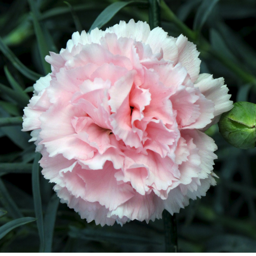

In [59]:
from fastdownload import download_url
dest = 'carnation.jpg'
download_url(urls[1], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

In [ ]:
searches = 'sunflower','rose', 'orchid', 'gladiolus', 'dahlia', 'hydrangea', 'anemone', 'lily', 'tulip', 'daisy', 'carnation', 'daffodil'
path = Path('flower_type_run2')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} different colors photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'sunflower photo'
Searching for 'sunflower sun photo'
Searching for 'sunflower shade photo'
Searching for 'sunflower different colors photo'
Searching for 'rose photo'
Searching for 'rose sun photo'
Searching for 'rose shade photo'
Searching for 'rose different colors photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'orchid photo'
Searching for 'orchid sun photo'
Searching for 'orchid shade photo'
Searching for 'orchid different colors photo'
Searching for 'gladiolus photo'
Searching for 'gladiolus sun photo'
Searching for 'gladiolus shade photo'
Searching for 'gladiolus different colors photo'
Searching for 'dahlia photo'
Searching for 'dahlia sun photo'
Searching for 'dahlia shade photo'
Searching for 'dahlia different colors photo'
Searching for 'hydrangea photo'
Searching for 'hydrangea sun photo'
Searching for 'hydrangea shade photo'
Searching for 'hydrangea different colors photo'
Searching for 'anemone photo'
Searching for 'anemone sun photo'
Searching for 'anemone shade photo'
Searching for 'anemone different colors photo'
Searching for 'lily photo'
Searching for 'lily sun photo'
Searching for 'lily shade photo'
Searching for 'lily different colors photo'
Searching for 'tulip photo'
Searching for 'tulip sun photo'
Searching for 'tulip shade photo'
Searching for 'tulip differe

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'daffodil photo'
Searching for 'daffodil sun photo'


In [61]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

20

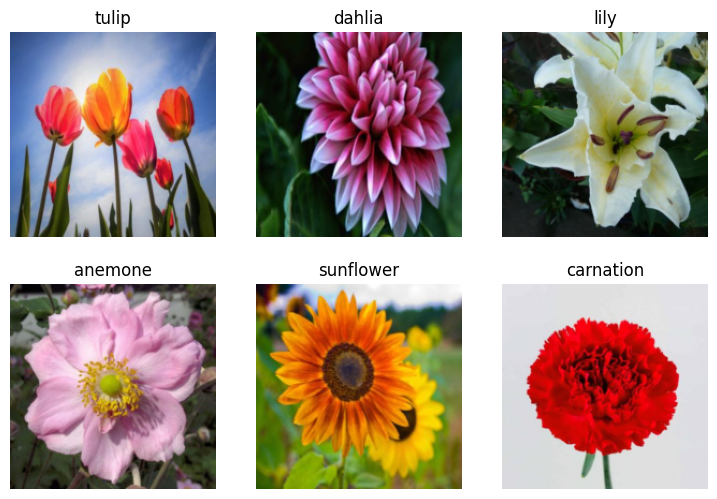

In [62]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [75]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.218411,0.156360,0.047794,02:55


epoch,train_loss,valid_loss,error_rate,time
0,0.097297,0.116269,0.047794,04:28
1,0.061434,0.102298,0.033088,04:27
2,0.033551,0.106788,0.036765,04:25
3,0.024111,0.094693,0.036765,04:24


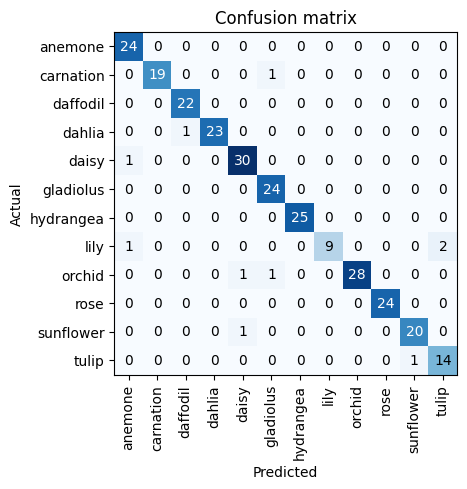

In [76]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

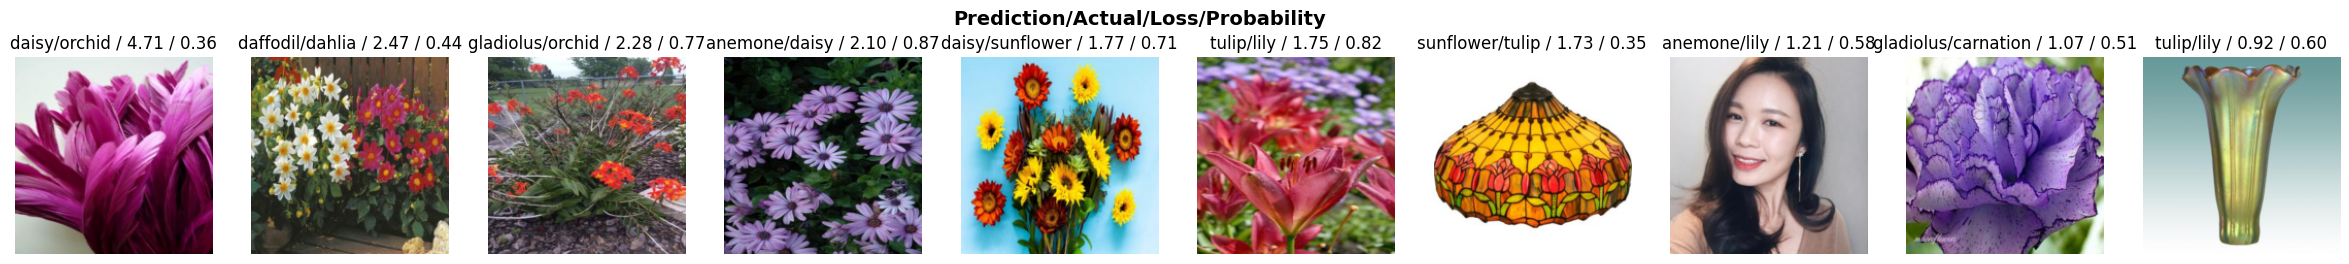

In [77]:
interp.plot_top_losses(10, nrows=1)

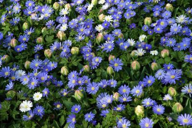

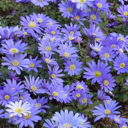

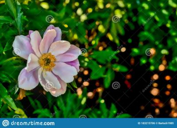

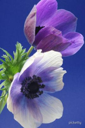

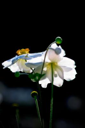

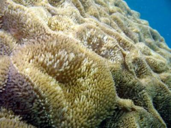

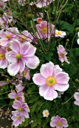

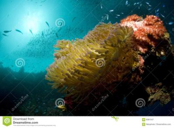

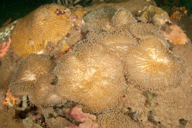

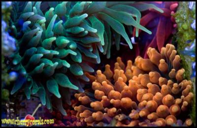

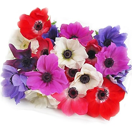

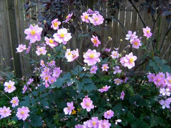

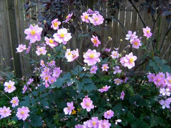

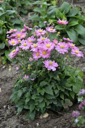

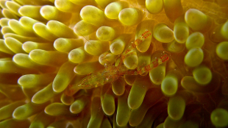

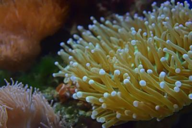

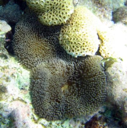

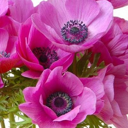

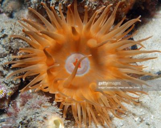

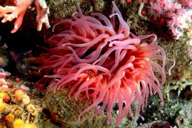

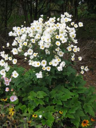

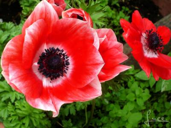

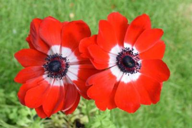

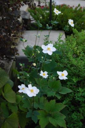

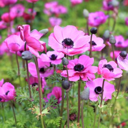

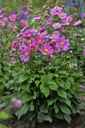

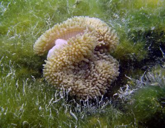

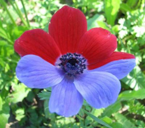

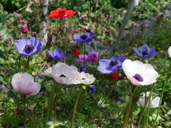

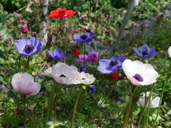

In [78]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [79]:
print(1)

1


In [86]:
learn.export('model_extended.pkl')

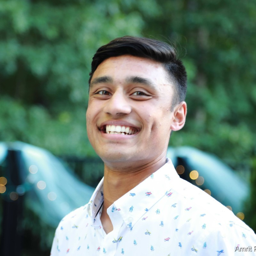

In [55]:
im = Image.open(dest)
im.to_thumb(256,256)

In [80]:
pred, idx, probs = learn.predict('carnation.jpg')
pred, idx, probs

('carnation',
 tensor(1),
 tensor([7.6154e-09, 1.0000e+00, 1.0094e-08, 3.0304e-08, 3.5051e-07, 8.9668e-08,
         4.7510e-08, 1.3810e-08, 1.4050e-08, 7.5402e-09, 5.4256e-08, 2.6563e-08]))

In [85]:
def classify_image(img):
    pred, idx, probs = learn.predict(img)
    return pred

classify_image('bird.jpg')

'sunflower'